In [1]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    size = vol.shape[1]
    # reshape for labeling
    seg = np.reshape(seg, (size, length*size) )
    vol = np.reshape(vol, (size, length*size) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=0)
    # shape back
    labeled = np.reshape(labeled, (length, size, size, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i], cmap='gray')
    axarr[1,1].imshow(patch.affinity[1][i], cmap='gray')
    axarr[1,2].imshow(patch.affinity[2][i], cmap='gray')
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()


def view_affinity(affinity,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,3)
    fig.set_size_inches(16, 10)
    axarr[0].imshow(affinity[0][i], cmap='gray')
    axarr[1].imshow(affinity[1][i], cmap='gray')
    axarr[2].imshow(affinity[2][i], cmap='gray')
    plt.show()

In [2]:
from neutorch.dataset.affinity import Dataset
from neutorch.dataset.ground_truth_volume import *

dataset = Dataset('../../data', patch_size=(26,256,256), length=100)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

loading file sample_A...


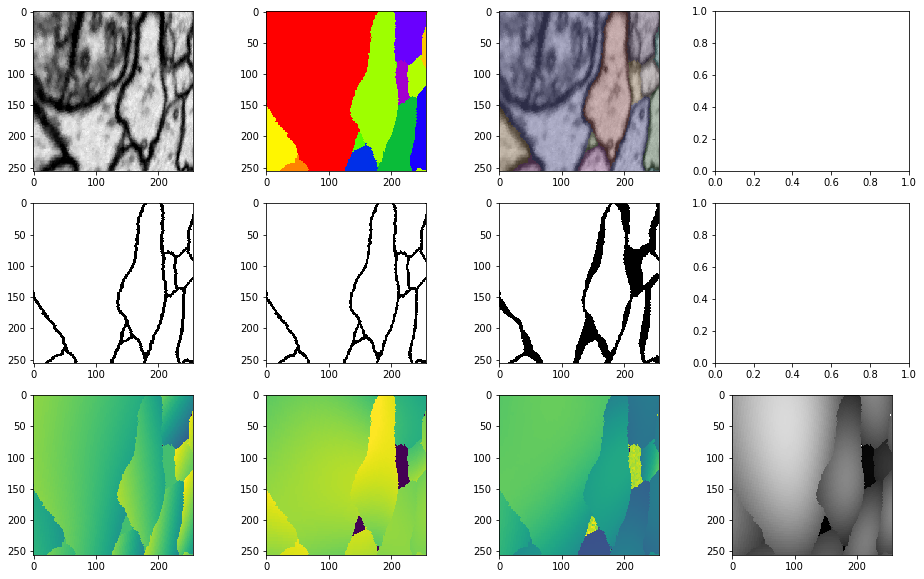

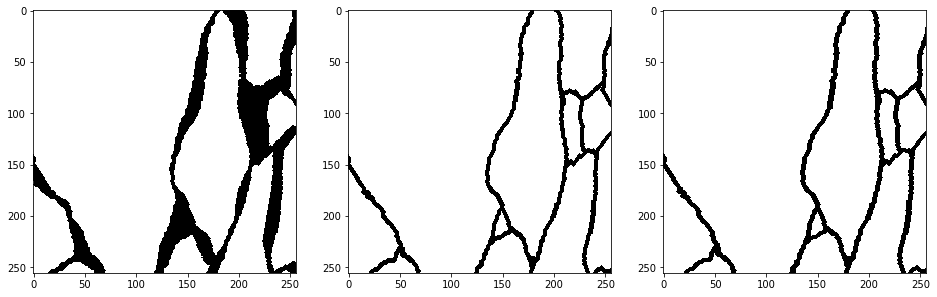

(3, 26, 256, 256)
Re-using already compiled waterz version
Preparing segmentation volume...
(26, 256, 256) {'V_Rand_split': 0.8996364579574041, 'V_Rand_merge': 0.9654162912030239, 'V_Info_split': 0.3752600497440328, 'V_Info_merge': 0.332203585177949}
129


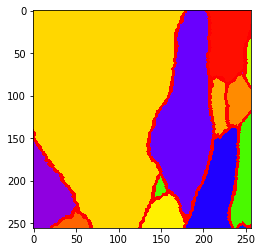

(26, 256, 256) {'V_Rand_split': 0.8996364579574041, 'V_Rand_merge': 0.9654162912030239, 'V_Info_split': 0.3752600497440328, 'V_Info_merge': 0.332203585177949}
129


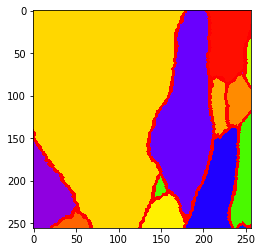

(26, 256, 256) {'V_Rand_split': 0.8998153834460192, 'V_Rand_merge': 0.1812261746724745, 'V_Info_split': 0.3697263389250711, 'V_Info_merge': 3.1992517326250427}
4


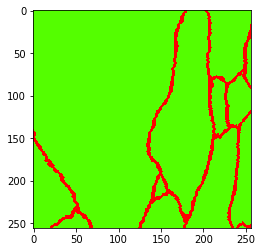

In [3]:
from waterz import agglomerate
import numpy as np

i = 5

patch = dataset.random_training_patch
affinity = patch.affinity
label = patch.label

view_patch(patch,i=i)
# affs is a [3, z, y, x] numpy array of float32
affs = np.flip(affinity, axis=0)
affs = np.ascontiguousarray(affs, dtype=np.float32) 

ground_truth = np.ascontiguousarray(label[0], dtype=np.uint32) 
thresholds = [0.1,1,10]
view_affinity(affs,i=i)
print(affs.shape)
seg_generator = agglomerate(affs, thresholds, gt=ground_truth,
       aff_threshold_low=0.1,
        aff_threshold_high=0.9,
        return_merge_history=True,
        return_region_graph=False)

for seg, metrics, merge_history in seg_generator:
        print(seg.shape, metrics)
        print(len(np.unique(seg)))
        plt.imshow(seg[i], cmap='prism')
        plt.show()


In [4]:
from waterz import agglomerate
import numpy as np
from neutorch.cremi.neuron_ids import NeuronIds
import math

def get_agglo(affs, thresholds):

    print(affs.shape, affs.dtype)
    # flip so affinity channel is z,y,x NOT x,y,z
    affs = np.flip(affs, axis=0)
    affs = np.ascontiguousarray(affs, dtype=np.float32) 

    seg_generator = agglomerate(affs, thresholds,
            aff_threshold_low=0.001,
            aff_threshold_high=0.999,
            return_merge_history=False,
            return_region_graph=False)

    res = []
    for seg in seg_generator:
        cur = seg.copy()
        res.append(cur)

    return res


def cremi_test(test, truth, border_threshold):
    neuron_ids_evaluation = NeuronIds(truth, border_threshold=border_threshold)
    (voi_split, voi_merge) = neuron_ids_evaluation.voi(test)
    adapted_rand = neuron_ids_evaluation.adapted_rand(test)
    cremi_score = math.sqrt((voi_split + voi_merge) * adapted_rand) # the geometric mean of (VOI split + VOI merge) and ARAND.
    
    print(f'voi_split: {voi_split}, voi_merge: {voi_merge}, adapted_rand: {adapted_rand}')
    print(f'CREMI score: {cremi_score}')



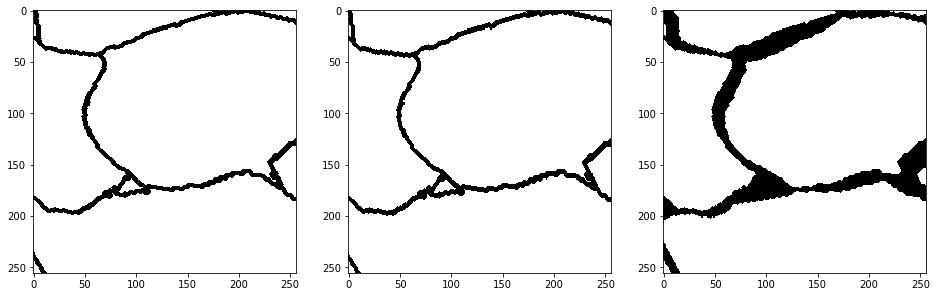

(3, 26, 256, 256) float32
Re-using already compiled waterz version
Preparing segmentation volume...


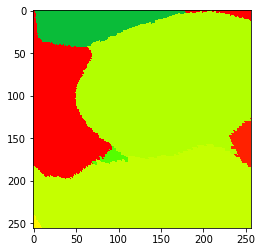

54
42


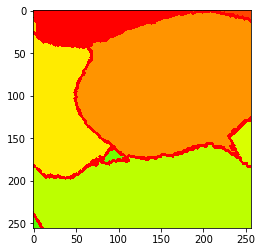

voi_split: 0.07276073468350858, voi_merge: 0.0005460252271028441, adapted_rand: 0.0010352006185537777
CREMI score: 0.00871132614494706
42


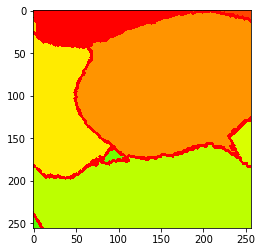

voi_split: 0.07276073468350858, voi_merge: 0.0005460252271028441, adapted_rand: 0.0010352006185537777
CREMI score: 0.00871132614494706
42


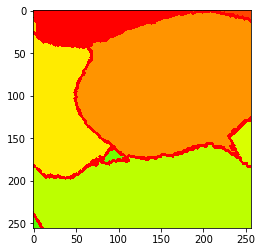

voi_split: 0.07276073468350858, voi_merge: 0.0005460252271028441, adapted_rand: 0.0010352006185537777
CREMI score: 0.00871132614494706
4


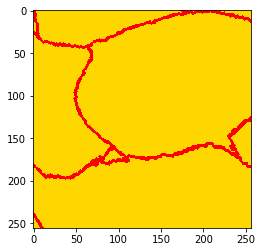

voi_split: 0.0035192519045441945, voi_merge: 1.4853446692986247, adapted_rand: 0.32433926310652406
CREMI score: 0.6949079270442421


In [5]:
patch = dataset.random_training_patch

affinity = patch.affinity
truth = np.squeeze(patch.label).astype(np.uint64)

thresholds = [0.1,0.7,1,10]
view_affinity(affinity)
tests = get_agglo(affinity, thresholds)

i=0
plt.imshow(truth[i], cmap='prism')
plt.show()
print(len(np.unique(truth)))
for test in tests:
    print(len(np.unique(test)))
    plt.imshow(test[i], cmap='prism')
    plt.show()
    cremi_test(test, truth, 1)
    

In [6]:
from neutorch.dataset.utils import from_h5

vol = from_h5(f'../../data/affs_160k_vol_04831.h5')
print(vol.dtype)
print(np.unique(vol[:,0:10,:,:],))


float32
[0.00746994 0.00772699 0.00802393 ... 0.9999999  0.99999994 1.        ]


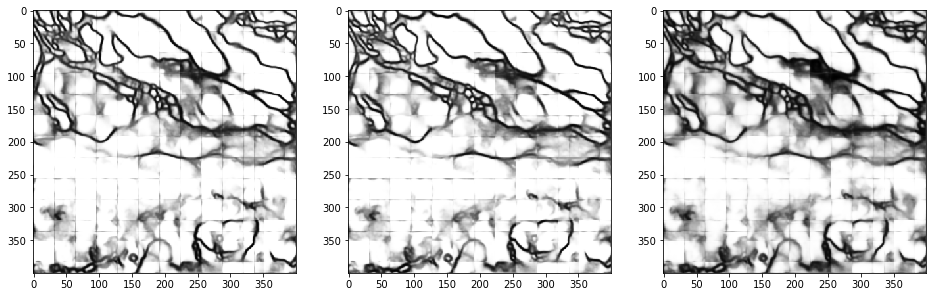

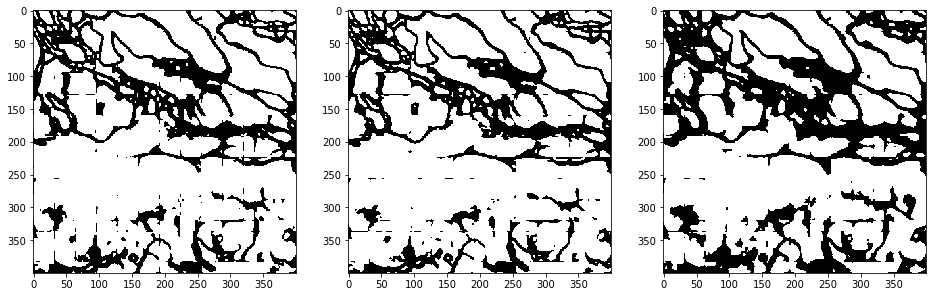

In [7]:
view_affinity(vol,i=0)
vol_trunc = np.where(vol > 0.7, 1.0, 0.0)
view_affinity(vol_trunc,i=0)

(3, 26, 256, 256) float64
Re-using already compiled waterz version
Preparing segmentation volume...
(26, 256, 256)
520


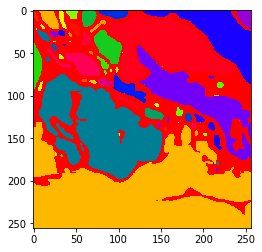

In [8]:
thresholds = [0.7]
vol = vol_trunc[:,:26,:256,:256]
segs =  get_agglo(vol, thresholds)

i = 0
for seg in segs:
        print(seg.shape)
        print(len(np.unique(seg)))
        plt.imshow(seg[i], cmap='prism')
        plt.show()

(3, 26, 256, 256)


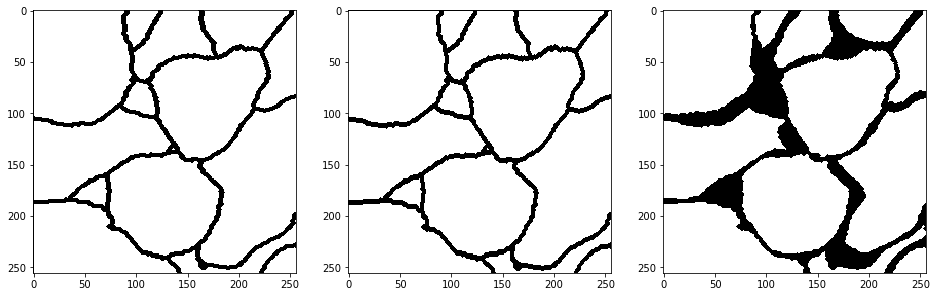

(3, 26, 256, 256) float64
Re-using already compiled waterz version
Preparing segmentation volume...


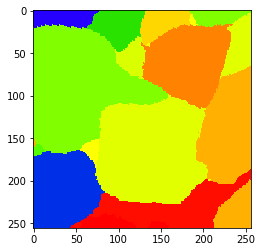

173
100


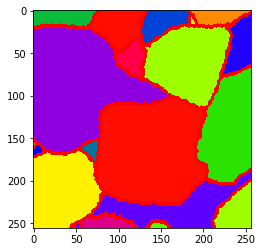

voi_split: 0.006889917333203742, voi_merge: 6.226444214085698e-05, adapted_rand: 5.2599919906359816e-05
CREMI score: 0.0006047182852846277
100


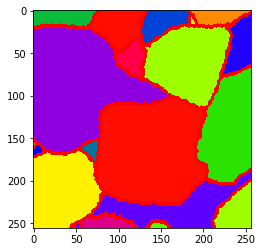

voi_split: 0.006889917333203742, voi_merge: 6.226444214085698e-05, adapted_rand: 5.2599919906359816e-05
CREMI score: 0.0006047182852846277
100


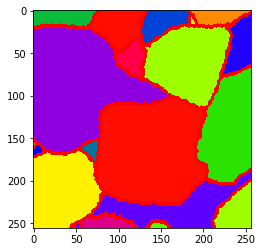

voi_split: 0.006889917333203742, voi_merge: 6.226444214085698e-05, adapted_rand: 5.2599919906359816e-05
CREMI score: 0.0006047182852846277
3


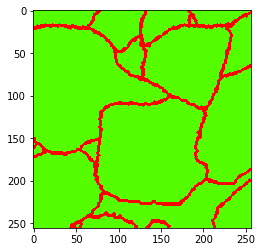

voi_split: 0.00017664177642559635, voi_merge: 3.195186064031551, adapted_rand: 0.7590071592285006
CREMI score: 1.5573384892309081


In [9]:
from neutorch.cremi.border_mask import create_border_mask
    
patch = dataset.random_training_patch
label = patch.label
label = np.squeeze(label)
z0, y0, x0 = label.shape
masked_label = np.zeros(label.shape, dtype=np.uint64)
max_dist = 1
create_border_mask(label, masked_label, max_dist, 0)

# along some axis X, affinity is 1 or 0 based on if voxel x === x-1
affinity = np.zeros((3, z0, y0, x0))
affinity[2, 1:, :, :] = masked_label[..., 1:, :,
                                        :] == masked_label[..., 0:-1, :, :]  # z channel
affinity[1, :, 1:, :] = masked_label[..., :, 1:,
                                        :] == masked_label[..., :, 0:-1, :]  # y channel
affinity[0, :, :, 1:] = masked_label[..., :, :,
                                        1:] == masked_label[..., :, :, 0:-1]  # x channel

# but back in background labels
affinity[:, masked_label == 0] = 0

print(affinity.shape)
truth = np.squeeze(patch.label).astype(np.uint64)

thresholds = [0.1,0.7,1,10]
view_affinity(affinity,i=5)
tests =  get_agglo(affinity, thresholds)

i=0
plt.imshow(truth[i], cmap='prism')
plt.show()
print(len(np.unique(truth)))
for test in tests:
    print(len(np.unique(test)))
    plt.imshow(test[i], cmap='prism')
    plt.show()
    cremi_test(test, truth, 1)




